In [1]:
from __future__ import print_function, division
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets, models, transforms, io
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interactive mode

ModuleNotFoundError: No module named 'torch'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_dir='/content/drive/MyDrive/Analytics_Vidya/CapStoneProject'
data_train = pd.read_csv(data_dir+'/train/train.csv')
data_test = pd.read_csv(data_dir+'/test_EtfZwUO.csv')
map_img_category_dict = {img:category for img, category in zip(data_train.image, data_train.category)}
ship_category = {1: 'Cargo',
                 2: 'Military',
                 3: 'Carrier',
                 4: 'Cruise',
                 5: 'Tankers'}

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
class DatasetPreprocessing(torch.utils.data.DataLoader):
    def __init__(self, phase='train', transform=None, img_dir='', csv_dir='', labels_dict = {}):

        self.phase = phase
        self.transform = transform[phase]
        self.img_dir = img_dir
        self.labels_dict = labels_dict
        self.imgs_list = pd.read_csv(csv_dir)['image'].tolist()
        if self.phase != 'test':
            self.labels_list = pd.read_csv(csv_dir)['category'].tolist()
        if self.phase == 'train':
            self.labels = [labels_dict[i] for i in self.imgs_list]
        else:
            self.labels = [0 for i in range(len(self.imgs_list))]

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, index):
        file_name = self.imgs_list[index]
        img_data=self.pil_loader(self.img_dir+"/"+file_name)

        if self.transform is not None:
            img_data = self.transform(img_data)

        if self.phase == 'test':
            label = file_name
        else:
            label = self.labels_list[index]

        return img_data, label

    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

In [6]:
train_data = DatasetPreprocessing("train", data_transforms, data_dir+"/train/images", data_dir+"/train/train.csv", map_img_category_dict)

In [7]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=5, shuffle=True)

In [8]:
len(train_data)

6252

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def imshow(img, title):

    #convert image from tensor to numpy for visualization
    npimg = img.numpy()
    #define the size of a figure
    plt.figure(figsize = (15, 15))
    plt.axis("off")

    #interchaging the image sizes - transposing
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title, fontsize=15)
    plt.show()

In [11]:
def show_batch_images(dataloader):

    #getting the images
    images, labels = next(iter(dataloader))
    #make a grid from those images
    img = torchvision.utils.make_grid(images)
    imshow(img, "classes: " + str([str(x.item())+ " "+ ship_category[x.item()] for x in labels]))

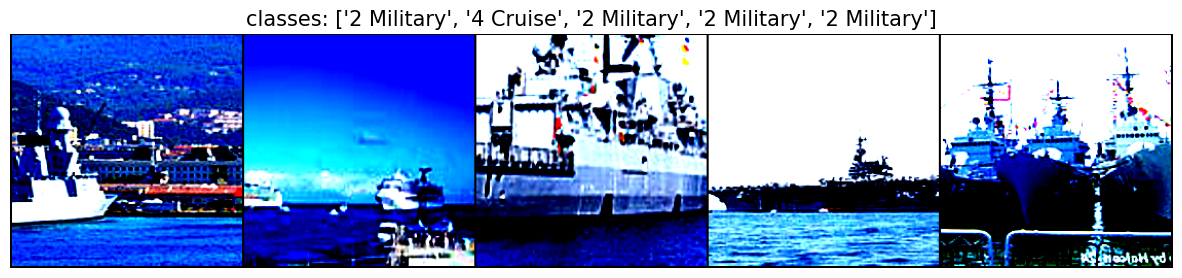

In [12]:
show_batch_images(train_dataloader)

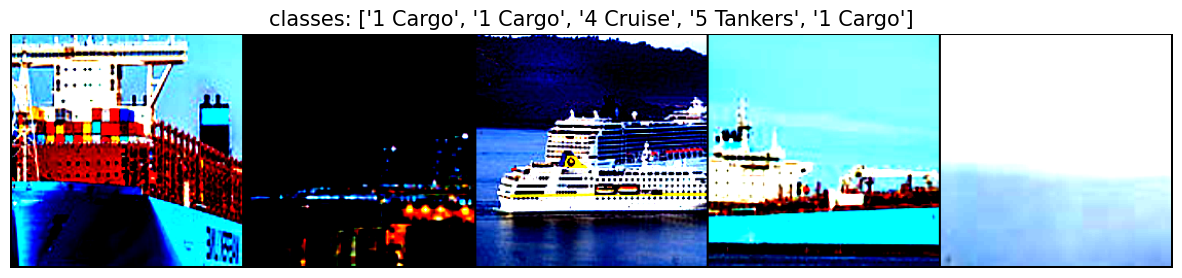

In [13]:
show_batch_images(train_dataloader)

In [14]:
train, valid = train_test_split(data_train.category, stratify=data_train.category, test_size=0.15, random_state=10)

### Batchsize and parallelize

training_batchsize = 16
num_workers = 4

#### Idx for train and valid
train_sampler = SubsetRandomSampler(list(train.index))
valid_sampler = SubsetRandomSampler(list(valid.index))

In [15]:
len(list(train.index))

5314

In [16]:
len(list(valid.index))

938

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=training_batchsize,sampler=train_sampler,num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


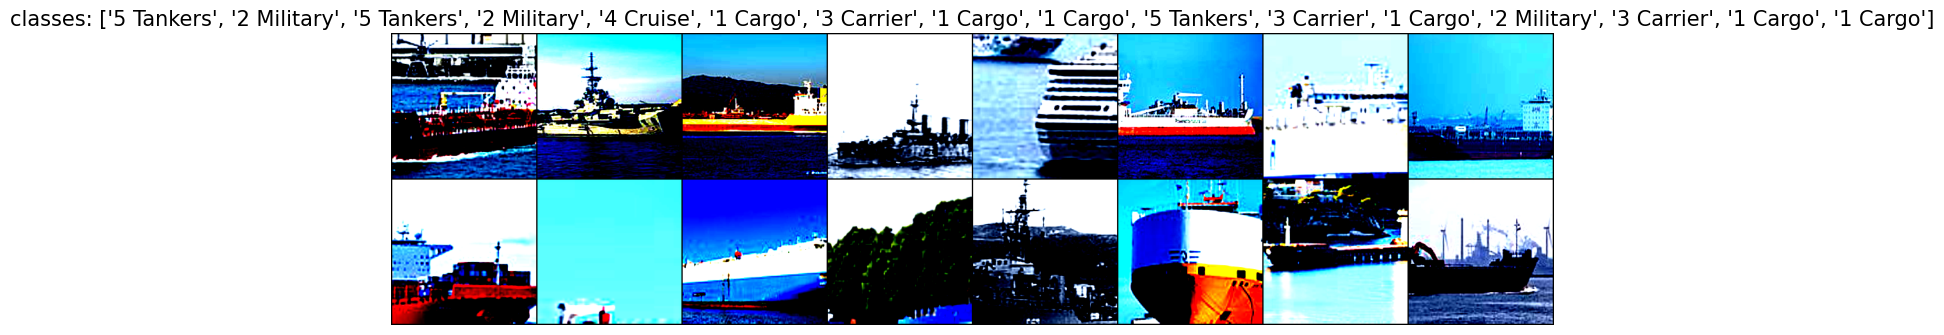

In [18]:
show_batch_images(train_dataloader)

In [19]:
valid_data =  DatasetPreprocessing("val", data_transforms, data_dir+"/train/images", data_dir+"/train/train.csv", map_img_category_dict)

In [20]:
valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=training_batchsize,sampler=valid_sampler,num_workers=num_workers)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
test_data = DatasetPreprocessing("test", data_transforms, data_dir+"/train/images", data_dir+"/test_EtfZwUO.csv", map_img_category_dict)

In [22]:
dataloaders = {"train": train_dataloader, "val": valid_dataloader}
dataset_sizes = {"train": len(list(train.index)), "val": len(list(valid.index))}

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses, test_losses = [], []
    train_acc, test_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device) - 1

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == "train":
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == "val":
                test_losses.append(epoch_loss)
                test_acc.append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    del inputs, labels
    torch.cuda.empty_cache()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    torch.save(model.state_dict(best_model_wts),"saved.pth")
    print("best model saved")

    model.load_state_dict(best_model_wts)
    return model, train_losses, test_losses, train_acc, test_acc

In [24]:
def make_predictions(dataloader, trained_model):

    pred = dict()
    trained_model.eval()

    for  data in dataloader:
        images, labels = data
        images = images.cuda()

        trained_model.cuda()
        outputs = trained_model(images)

        for i in range(len(images)):
            detect_class = torch.argmax(outputs[i]).item() + 1
            pred[labels[i]] = detect_class

    df = pd.DataFrame(list(pred.items()), columns=['image', 'category'])
    return(df)

In [25]:
#Redefine a model
class my_model():
    def __init__(self, num_class, model):
        self.model = model
        self.num_class = num_class
        base_layers = list(self.model.children())
        last_base_layer = base_layers[-1]
        if type(last_base_layer) == (torch.nn.modules.container.Sequential):
            child_module = list(last_base_layer)
            for i in reversed(child_module):
                if type(i) == torch.nn.modules.linear.Linear:
                    i.out_features = num_class
                    break
        elif type(last_base_layer) == torch.nn.modules.linear.Linear:
            last_base_layer.out_features = num_class

In [26]:
model_ft = my_model(num_class=5, model=models.mnasnet1_0(pretrained = True)).model

print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mnasnet1.0_top1_73.512-f206786ef8.pth" to /root/.cache/torch/hub/checkpoints/mnasnet1.0_top1_73.512-f206786ef8.pth
100%|██████████| 16.9M/16.9M [00:00<00:00, 44.7MB/s]


MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

In [27]:
criterion = nn.CrossEntropyLoss()

model_ft = model_ft.to(device)

#optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=0.0001, weight_decay=1e-3)
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

scheduler_cosineAL = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, len(train_dataloader), eta_min=1e-6)

In [ ]:
model_trained, train_lr, test_lr,train_acc, test_acc = train_model(model_ft, criterion, optimizer_ft, scheduler_cosineAL, num_epochs=80)

Epoch 0/79
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Loss: 2.0712 Acc: 0.5478
val Loss: 8.4024 Acc: 0.0171
Epoch 1/79
----------
train Loss: 0.7202 Acc: 0.7407
val Loss: 5.4381 Acc: 0.1269
Epoch 2/79
----------
train Loss: 0.5958 Acc: 0.7845
val Loss: 3.3298 Acc: 0.3241
Epoch 3/79
----------
train Loss: 0.5333 Acc: 0.8056
val Loss: 1.9043 Acc: 0.5597
Epoch 4/79
----------
train Loss: 0.4885 Acc: 0.8141
val Loss: 1.3823 Acc: 0.6567
Epoch 5/79
----------


In [ ]:
plt.plot(train_lr, label='Training loss')
plt.plot(test_lr, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [ ]:
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=training_batchsize,num_workers=num_workers)
test_df = make_predictions(test_dataloader, model_trained)
len(test_data)

In [ ]:
test_df.head()
test_df.to_csv(path_or_buf=data_dir+'/submission.csv', encoding='utf-8' )

In [ ]:
test_df.category.value_counts()